# Feature selection
In this notebook, we cover the process that led to the selection of useful features in the dataset, including statistical tests

In [1]:
# Import relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import statUtils as su
import utils as ut

In [2]:
JOIN_PATH = "../../assets/joined/"
CLEAN_PATH_DEV = "../../assets/clean/"
CLEAN_PATH_COMP = "../../assets/kaggleClean/"

account_data = pd.read_csv(CLEAN_PATH_DEV +  "account.csv")
card_data = pd.read_csv(CLEAN_PATH_DEV + "card_dev.csv")
client_data = pd.read_csv(CLEAN_PATH_DEV + "client.csv")
disp_data = pd.read_csv(CLEAN_PATH_DEV + "disp.csv", dtype={"disp_id": int, "client_id": int, "account_id": int, "type": str})
district_data = pd.read_csv(CLEAN_PATH_DEV + "district.csv")
loan_data = pd.read_csv(CLEAN_PATH_DEV + "loan_dev.csv")
transaction_data = pd.read_csv(CLEAN_PATH_DEV + "trans_dev.csv", dtype=
    {"trans_id": int, "account_id": int, "date": str, "type": str, "operation": str, "amount": float, "balance": float, "k_symbol": str, "bank": str, "account": str}
)

JOIN_FILE_DEV = "data.csv"
JOIN_FILE_COMP = "kaggleData.csv"

joined_data = pd.read_csv(JOIN_PATH + JOIN_FILE_DEV, dtype={"code_aDistrict": int, "code_cDistrict": int})
joined_data_comp = pd.read_csv(JOIN_PATH + JOIN_FILE_COMP, dtype={"code_aDistrict": int, "code_cDistrict": int})

IS_LOADED = False

In [3]:
# Change pandas display options
# pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

### Transactions analysis

Verify the correlation between the *type* and *operation* columns of Transactions

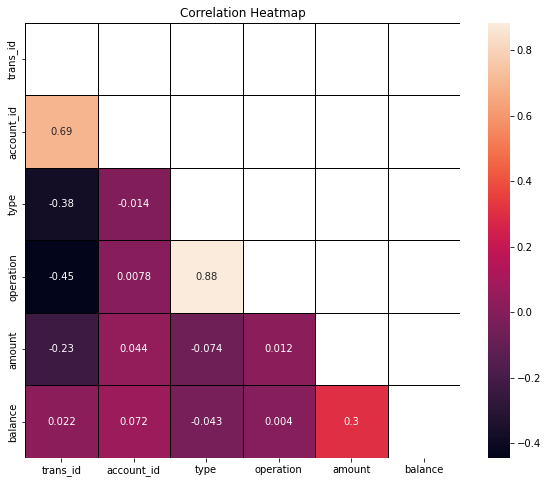

In [4]:
if not IS_LOADED:
    # convert 'type' and 'operation' columns to numeric catorical values
    transaction_data['type'] = transaction_data['type'].astype('category').cat.codes
    transaction_data['operation'] = transaction_data['operation'].astype('category').cat.codes

su.plot_corr(transaction_data, transaction_data.columns, methodName="spearman", annot=True, figSize=(10, 8))


As we can see, the 'type' and 'operation' columns have a very high correlation. This proves what we mentioned in [Data Analysis](./dataAnalysis.ipynb) and for that reason we can ignore one of them. The preferred attribute to mantain is the *type*, since it does not suffer from consistency issues

--------------

## Feature Engineering

Most models and correlation algorithms handle numerical data better. For this reason, we will try to convert the possible fields to this type

### Dates -> Numerical
Currently, dates are in the format "YYYY-MM-DD", we will convert them to "YYMMDD". 
But first, we will add a new column for the client's age at the time of the loan:

In [5]:
def find_year(df):
    # Create a new age column with the client's age
    loan_dates = pd.to_datetime(df["loan_date"], format="%Y-%m-%d")
    birth_dates = pd.to_datetime(df["birth_number"], format="%Y-%m-%d")

    client_ages = []
    for i in range(len(loan_dates)):
        # A bool that represents if the loan's day/month precedes the birth date's day/month
        year_offset = (loan_dates[i].month, loan_dates[i].day) < (birth_dates[i].month, birth_dates[i].day)

        year_diff = loan_dates[i].year - birth_dates[i].year

        # Subtract the offset from the year difference to take into account the month and day in the age calculation
        client_ages.append(year_diff - year_offset)
    df["age"] = client_ages


if not IS_LOADED:
    find_year(joined_data)
    find_year(joined_data_comp)

Now analyzing the distribution of age and its relation with other variables:

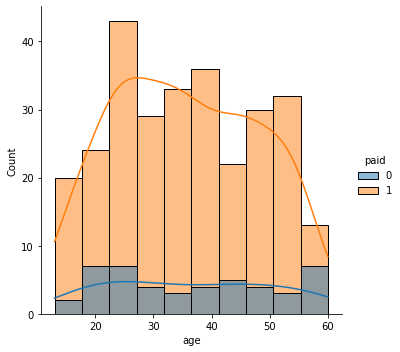

In [6]:
sb.displot(x="age", data=joined_data, kde=True, hue="paid")

As we can see, some age groups have a lower ratio of paid_loans, especially the 55-60 group

<AxesSubplot:xlabel='age', ylabel='balance_mean'>

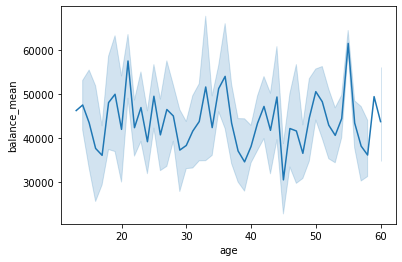

In [7]:
sb.lineplot(x="age", y="balance_mean", data=joined_data)

Surprisingly, the balance mean does not seem to change significantly with the age

### Client's age discretization
By observing the graph above, we can detect age groups where the ratio of paid loans is different

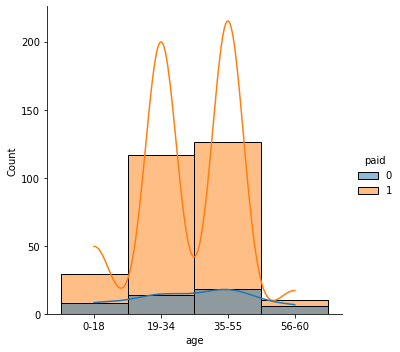

In [8]:
age_intervals = [0, 19, 35, 56, 61, 150]
age_intervals_labels = ['0-18', '19-34', '35-55', '56-60', 'retired']
def discretize_ages(df):
    df['age'] = pd.cut(x = df['age'], bins = age_intervals, labels=age_intervals_labels)

if not IS_LOADED:
    discretize_ages(joined_data)
    discretize_ages(joined_data_comp)

sb.displot(x="age", data=joined_data, kde=True, hue="paid")

### Alter Age format to a number
`age` is a categorical value that represents a range. Instead of storing it as a string however, it can be represented by an integer based on a defined enum. The `age` values are now:
- 0 -> [0,18]
- 1 -> [19,34]
- 2 -> [35,55]
- 3 -> [56-60]
- 4 -> retired

In [9]:
ageToInt = {
    "0-18": 0,
    "19-34": 1,
    "35-55": 2,
    "56-60": 3,
    "retired": 4
}

def parse_init_age_range(df):
    def parse_init_inner(row):
        age = row['age']
        return int(ageToInt[age])

    df['age'] = df.apply(parse_init_inner, axis=1)
    
if not IS_LOADED:
    parse_init_age_range(joined_data)
    parse_init_age_range(joined_data_comp)

## Remove types of card

As seen in `dataAnalysis.ipynb`, there are very few clients with card type that have any paid result.
Thus, we will discard the columns related to it

In [10]:
cardDropCols = ['card_type', 'card_issued']

joined_data.drop(cardDropCols, axis='columns', inplace=True)
joined_data_comp.drop(cardDropCols, axis='columns', inplace=True)

joined_data

,frequency,a_date,is_co-owned,birth_number,gender,code_aDistrict,name_aDistrict,region_aDistrict,num_inhabitants_aDistrict,municip499_aDistrict,municip500_1999_aDistrict,municip2000_9999_aDistrict,municip10000_aDistrict,num_cities_aDistrict,urban_ratio_aDistrict,avg_salary_aDistrict,unemp_rate95_aDistrict,unemp_rate96_aDistrict,num_entrepreneurs_aDistrict,num_crimes95_aDistrict,num_crimes96_aDistrict,num_crimes95_ratio_aDistrict,num_crimes96_ratio_aDistrict,code_cDistrict,name_cDistrict,region_cDistrict,num_inhabitants_cDistrict,municip499_cDistrict,municip500_1999_cDistrict,municip2000_9999_cDistrict,municip10000_cDistrict,num_cities_cDistrict,urban_ratio_cDistrict,avg_salary_cDistrict,unemp_rate95_cDistrict,unemp_rate96_cDistrict,num_entrepreneurs_cDistrict,num_crimes95_cDistrict,num_crimes96_cDistrict,num_crimes95_ratio_cDistrict,num_crimes96_ratio_cDistrict,loan_id,loan_date,amount,duration,payments,paid,sanctions,household_mean,interest_mean,prev_year_balance,prev_6m_balance,prev_1m_balance,balance_min,balance_max,balance_mean,mean_year_influx,mean_6m_influx,mean_3m_influx,age
0,weekly issuance,1993-03-22,0,1947-07-22,0,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100.0,2985.0,2804.0,31.483357,29.574315,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100.0,2985.0,2804.0,31.483357,29.574315,5314,1993-07-05,96396,12,8033,0,0,7266.0,128.930000,12250.000000,12250.000000,20100.000000,1100.0,20100.0,12250.000000,1675.000000,3350.000000,6333.333333,2
1,monthly issuance,1993-02-13,0,1968-07-22,1,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117.0,2854.0,2618.0,25.321847,23.227959,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117.0,2854.0,2618.0,25.321847,23.227959,5316,1993-07-11,165960,36,4610,1,0,15925.0,118.091667,52083.859459,52083.859459,33113.788889,700.0,120512.8,52083.859459,4350.741667,8701.483333,-12278.966667,1
2,monthly issuance,1993-02-08,0,1936-06-02,1,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132.0,2080.0,2122.0,26.695073,27.234108,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132.0,2080.0,2122.0,26.695073,27.234108,6863,1993-07-28,127080,60,2118,1,0,6393.0,193.711111,30060.954167,30060.954167,36233.066667,800.0,49590.4,30060.954167,1689.416667,3378.833333,-2448.833333,3
3,monthly issuance,1993-01-30,0,1940-04-20,0,14,Ceske Budejovice,south Bohemia,177686,69,27,10,1,9,74.8,10045,1.42,1.71,135.0,6604.0,6295.0,37.166687,35.427665,12,Pribram,central Bohemia,107870,84,29,6,1,6,58.0,8754,3.83,4.31,137.0,3804.0,3868.0,35.264670,35.857977,5325,1993-08-03,105804,36,2939,1,0,0.0,252.633333,41297.480000,42976.541667,42535.133333,1000.0,65898.5,41297.480000,2857.716667,5548.766667,-990.000000,2
4,weekly issuance,1993-02-14,0,1978-09-07,1,63,Vyskov,south Moravia,86513,38,36,5,1,5,50.5,8288,3.79,4.52,110.0,1562.0,1460.0,18.055090,16.876076,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167.0,85677.0,99107.0,71.104018,82.249681,7240,1993-09-06,274740,60,4579,1,0,6256.0,122.200000,57188.211111,59364.680769,49872.757143,600.0,122893.1,57188.211111,3426.091667,6752.183333,-6138.033333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,monthly issuance,1995-01-21,1,1971-04-10,0,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.80,4.79,110.0,9672.0,9208.0,42.773370,40.721380,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.80,4.79,110.0,9672.0,9208.0,42.773370,40.721380,6818,1996-12-12,155616,48,3242,1,0,9810.0,213.500000,45928.792079,43900.685714,54345.971429,200.0,75294.1,44197.509884,-39.675000,-2094.533333,2870.900000,1
324,monthly issuance,1995-11-29,0,1939-03-20,1,29,Rokycany,west Bohemia,45714,52,10,5,1,6,55.6,8843,2.82,3.60,113.0,818.0,888.0,17.893862,19.425121,29,Rokycany,west Bohemia,45714,52,10,5,1,6,55.

## Analysis of the Client's info attributes

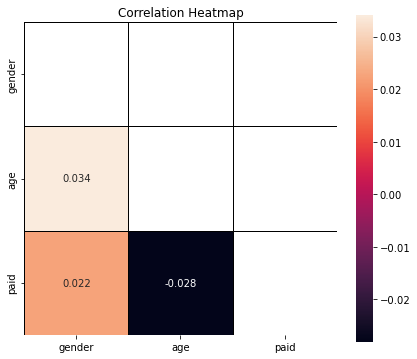

In [11]:
clientInfoCols = ["gender", "age"]

su.plot_corr(joined_data, clientInfoCols + ["paid"], methodName="spearman", annot=True, figSize=(7, 6))

If we perform a *chi-square test of Independence* to determine whether or not there is a significant association between the `clientInfoCols` and the `paid` property, we get the following results: 

In [12]:
su.chi_square_test(joined_data, clientInfoCols)

chi2:  13.875787772825582
p:  0.05343520827893905
dof:  7
expected:  [[ 2.94512195  8.55487805 10.79878049  0.42073171  2.24390244  9.81707317
   9.39634146  1.82317073]
 [18.05487805 52.44512195 66.20121951  2.57926829 13.75609756 60.18292683
  57.60365854 11.17682927]]
H0 accepted


Hence, the *Null Hypothesis* is accepted, confirming that there is no significant association between these variables

As shown above, the `gender` and `age` columns are not correlated. Furthermore, the gender column do not appear to be very correlated with the `paid` property. Meaning that gender will probably not be very helpful in the prediction of the `paid` property, but age can be.

Furthermore, the `birth_number` column will be dropped, since it's information is already contained in the `age` column

In [13]:
joined_data.drop(['birth_number'], axis='columns', inplace=True)
joined_data_comp.drop(['birth_number'], axis='columns', inplace=True)

## District Extraction

### Handling categorical data

In [14]:
print("Number of different 'code' values:", len(joined_data['code_aDistrict'].value_counts()))
print("Number of different 'name' values:", len(joined_data['name_aDistrict'].value_counts()))

Number of different 'code' values: 73
Number of different 'name' values: 73


There is a direct association between the `code` and `name` columns. For this reason, we don't need store both, and we can drop the `code` column and use `name` to encode.

However, we cannot use the `code` column as is, since it is a categorical value. We will convert it to a numerical value by using the *Target Encoding* technique. This technique consists of replacing each category with the mean of the target for that category. In our case, the target is the `paid` property. To circumvent the issue of overfitting to the training data, [CatBoost Encoding](https://www.geeksforgeeks.org/categorical-encoding-with-catboost-encoder/#:~:text=Catboost%20is%20one%20of%20them,technique%20used%20for%20categorical%20encoding.) was used.

In [15]:
import utils as ut

if not IS_LOADED:
    joined_data['code_aDistrict'] = joined_data['code_aDistrict'].astype(str)
    joined_data['code_cDistrict'] = joined_data['code_cDistrict'].astype(str)

    joined_data_comp['code_aDistrict'] = joined_data_comp['code_aDistrict'].astype(str)
    joined_data_comp['code_cDistrict'] = joined_data_comp['code_cDistrict'].astype(str)

    (joined_data, joined_data_comp) = ut.cat_boost_encode(joined_data, ['code_aDistrict', 'code_cDistrict'], joined_data_comp)

    # Drop unused columns
    joined_data.drop(['name_aDistrict', 'name_cDistrict'], axis='columns', inplace=True)
    joined_data.rename(columns={'code_aDistrict': 'a_district', 'code_cDistrict': 'c_district'}, inplace=True)

    joined_data_comp.drop(['name_aDistrict', 'name_cDistrict'], axis='columns', inplace=True)
    joined_data_comp.rename(columns={'code_aDistrict': 'a_district', 'code_cDistrict': 'c_district'}, inplace=True)




The `region` property is also categorical and does not contain a particular order. For this reason, we should also use the *Target Encoding* technique in order to remove its categorical nature.

In [16]:
if not IS_LOADED:
    (joined_data, joined_data_comp) = ut.cat_boost_encode(joined_data, ['region_aDistrict', 'region_cDistrict'], joined_data_comp)
   
    # Drop unused columns
    joined_data.rename(columns={'region_aDistrict': 'a_region', 'region_cDistrict': 'c_region'}, inplace=True)
    joined_data_comp.rename(columns={'region_aDistrict': 'a_region', 'region_cDistrict': 'c_region'}, inplace=True)



In [17]:
## Rename district cols
joined_data.rename(columns=
    {'num_inhabitants_aDistrict': 'a_num_inhabitants', 'municip499_aDistrict': 'a_municip499', 'municip500_1999_aDistrict': 'a_municip500_1999',
    'municip2000_9999_aDistrict': 'a_municip2000_9999', 'municip10000_aDistrict': 'a_municip10000', 'num_cities_aDistrict': 'a_num_cities',
    'urban_ratio_aDistrict': 'a_urban_ratio', 'avg_salary_aDistrict': 'a_avg_salary', 'unemp_rate95_aDistrict': 'a_unemp_rate95',
    'unemp_rate96_aDistrict': 'a_unemp_rate96', 'num_entrepreneurs_aDistrict': 'a_num_entrepreneurs', 'num_crimes95_aDistrict': 'a_num_crimes95',
    'num_crimes96_aDistrict': 'a_num_crimes96', 'num_crimes95_ratio_aDistrict': 'a_num_crimes95_ratio', 'num_crimes96_ratio_aDistrict': 'a_num_crimes96_ratio',
    'num_inhabitants_cDistrict': 'c_num_inhabitants', 'municip499_cDistrict': 'c_municip499', 'municip500_1999_cDistrict': 'c_municip500_1999',
    'municip2000_9999_cDistrict': 'c_municip2000_9999', 'municip10000_cDistrict': 'c_municip10000', 'num_cities_cDistrict': 'c_num_cities',
    'urban_ratio_cDistrict': 'c_urban_ratio', 'avg_salary_cDistrict': 'c_avg_salary', 'unemp_rate95_cDistrict': 'c_unemp_rate95',
    'unemp_rate96_cDistrict': 'c_unemp_rate96', 'num_entrepreneurs_cDistrict': 'c_num_entrepreneurs', 'num_crimes95_cDistrict': 'c_num_crimes95',
    'num_crimes96_cDistrict': 'c_num_crimes96', 'num_crimes95_ratio_cDistrict': 'c_num_crimes95_ratio', 'num_crimes96_ratio_cDistrict': 'c_num_crimes96_ratio'},
inplace=True)

joined_data_comp.rename(columns=
    {'num_inhabitants_aDistrict': 'a_num_inhabitants', 'municip499_aDistrict': 'a_municip499', 'municip500_1999_aDistrict': 'a_municip500_1999',
    'municip2000_9999_aDistrict': 'a_municip2000_9999', 'municip10000_aDistrict': 'a_municip10000', 'num_cities_aDistrict': 'a_num_cities',
    'urban_ratio_aDistrict': 'a_urban_ratio', 'avg_salary_aDistrict': 'a_avg_salary', 'unemp_rate95_aDistrict': 'a_unemp_rate95',
    'unemp_rate96_aDistrict': 'a_unemp_rate96', 'num_entrepreneurs_aDistrict': 'a_num_entrepreneurs', 'num_crimes95_aDistrict': 'a_num_crimes95',
    'num_crimes96_aDistrict': 'a_num_crimes96', 'num_crimes95_ratio_aDistrict': 'a_num_crimes95_ratio', 'num_crimes96_ratio_aDistrict': 'a_num_crimes96_ratio',
    'num_inhabitants_cDistrict': 'c_num_inhabitants', 'municip499_cDistrict': 'c_municip499', 'municip500_1999_cDistrict': 'c_municip500_1999',
    'municip2000_9999_cDistrict': 'c_municip2000_9999', 'municip10000_cDistrict': 'c_municip10000', 'num_cities_cDistrict': 'c_num_cities',
    'urban_ratio_cDistrict': 'c_urban_ratio', 'avg_salary_cDistrict': 'c_avg_salary', 'unemp_rate95_cDistrict': 'c_unemp_rate95',
    'unemp_rate96_cDistrict': 'c_unemp_rate96', 'num_entrepreneurs_cDistrict': 'c_num_entrepreneurs', 'num_crimes95_cDistrict': 'c_num_crimes95',
    'num_crimes96_cDistrict': 'c_num_crimes96', 'num_crimes95_ratio_cDistrict': 'c_num_crimes95_ratio', 'num_crimes96_ratio_cDistrict': 'c_num_crimes96_ratio'},
inplace=True)

In [18]:
accDistrictCols = ["a_district", "a_region", "a_num_inhabitants", "a_municip499", "a_municip500_1999", "a_municip2000_9999", "a_municip10000", 
    "a_num_cities", "a_urban_ratio", "a_avg_salary", "a_unemp_rate95", "a_unemp_rate96", "a_num_entrepreneurs", "a_num_crimes95", "a_num_crimes96", 
    "a_num_crimes95_ratio", "a_num_crimes96_ratio", "c_district"]

Let's see the correlation between the district related fields:

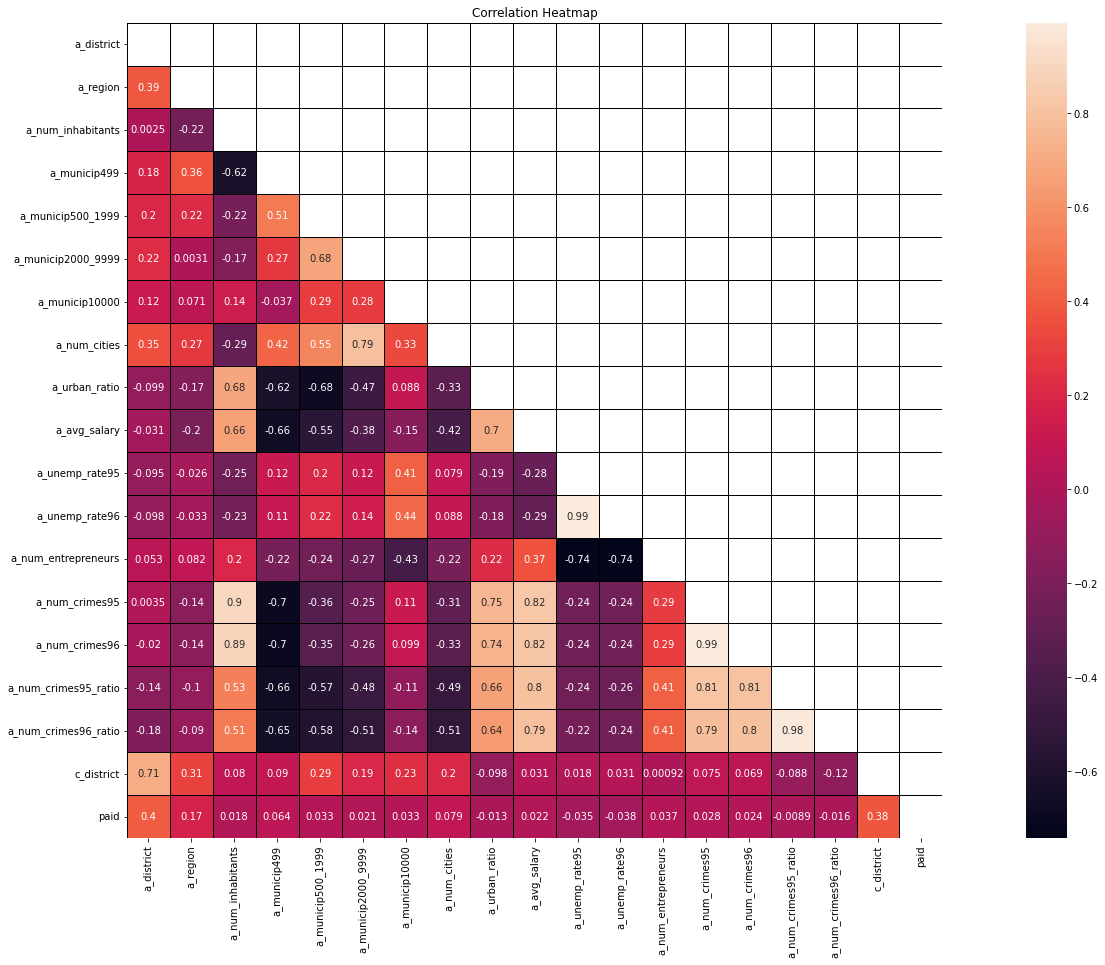

In [19]:
su.plot_corr(joined_data, accDistrictCols + ["paid"], methodName="spearman", annot=True, figSize=(30, 15))

Notice that the `client` district fields are not present, except the `c_district`, since the correlation between the account and client's district can be verified by that unique property. Some other relevant observations are:
- The correlation between the number of crimes and the number of inhabitants is very high. This is expected, since the number of crimes is a direct consequence of the number of inhabitants. On another note, the variable we created for the crimes ratio has a much lower correlation.
- The average salary is highly correlated to the number of inhabitants, urban ratio, and the number of crimes. 

From the graph above, we have a lot of low correlation columns with paid columns, so we will remove them
We'll leave the avg_salary since it can be important but not directly related with paid 

In [20]:
#drop columns with a correlation with paid lower than 0.1
joined_data.drop(['a_num_inhabitants', 'a_municip499', 'a_municip500_1999', 'a_municip2000_9999', 'a_municip10000', 'a_num_cities', 
  'a_urban_ratio', 'a_unemp_rate95', 'a_unemp_rate96', 'a_num_entrepreneurs', 'a_num_crimes95', 'a_num_crimes96', 'a_num_crimes95_ratio'], axis='columns', inplace=True) 

#"a_num_crimes96_ratio"

joined_data_comp.drop(['a_num_inhabitants', 'a_municip499', 'a_municip500_1999', 'a_municip2000_9999', 'a_municip10000', 'a_num_cities', 
  'a_urban_ratio', 'a_unemp_rate95', 'a_unemp_rate96', 'a_num_entrepreneurs', 'a_num_crimes95', 'a_num_crimes96', 'a_num_crimes95_ratio'], axis='columns', inplace=True)
#"a_num_crimes96_ratio"

joined_data

,frequency,a_date,is_co-owned,gender,a_district,a_region,a_avg_salary,a_num_crimes96_ratio,c_district,c_region,c_num_inhabitants,c_municip499,c_municip500_1999,c_municip2000_9999,c_municip10000,c_num_cities,c_urban_ratio,c_avg_salary,c_unemp_rate95,c_unemp_rate96,c_num_entrepreneurs,c_num_crimes95,c_num_crimes96,c_num_crimes95_ratio,c_num_crimes96_ratio,loan_id,loan_date,amount,duration,payments,sanctions,household_mean,interest_mean,prev_year_balance,prev_6m_balance,prev_1m_balance,balance_min,balance_max,balance_mean,mean_year_influx,mean_6m_influx,mean_3m_influx,age,paid
0,weekly issuance,1993-03-22,0,0,0.859756,0.801928,9650,29.574315,0.619919,0.776867,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100.0,2985.0,2804.0,31.483357,29.574315,5314,1993-07-05,96396,12,8033,0,7266.0,128.930000,12250.000000,12250.000000,20100.000000,1100.0,20100.0,12250.000000,1675.000000,3350.000000,6333.333333,2,0
1,monthly issuance,1993-02-13,0,1,0.964939,0.923409,8369,23.227959,0.859756,0.891046,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117.0,2854.0,2618.0,25.321847,23.227959,5316,1993-07-11,165960,36,4610,0,15925.0,118.091667,52083.859459,52083.859459,33113.788889,700.0,120512.8,52083.859459,4350.741667,8701.483333,-12278.966667,1,1
2,monthly issuance,1993-02-08,0,1,0.971951,0.923409,8390,27.234108,0.971951,0.891046,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132.0,2080.0,2122.0,26.695073,27.234108,6863,1993-07-28,127080,60,2118,0,6393.0,193.711111,30060.954167,30060.954167,36233.066667,800.0,49590.4,30060.954167,1689.416667,3378.833333,-2448.833333,3,1
3,monthly issuance,1993-01-30,0,0,0.976626,0.808117,10045,35.427665,0.837108,0.899018,107870,84,29,6,1,6,58.0,8754,3.83,4.31,137.0,3804.0,3868.0,35.264670,35.857977,5325,1993-08-03,105804,36,2939,0,0.0,252.633333,41297.480000,42976.541667,42535.133333,1000.0,65898.5,41297.480000,2857.716667,5548.766667,-990.000000,2,1
4,weekly issuance,1993-02-14,0,1,0.971951,0.882025,8288,16.876076,0.848080,0.848080,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167.0,85677.0,99107.0,71.104018,82.249681,7240,1993-09-06,274740,60,4579,0,6256.0,122.200000,57188.211111,59364.680769,49872.757143,600.0,122893.1,57188.211111,3426.091667,6752.183333,-6138.033333,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,monthly issuance,1995-01-21,1,0,0.805432,0.766534,8994,40.721380,0.885976,0.785765,226122,32,50,7,4,4,62.6,8994,3.80,4.79,110.0,9672.0,9208.0,42.773370,40.721380,6818,1996-12-12,155616,48,3242,0,9810.0,213.500000,45928.792079,43900.685714,54345.971429,200.0,75294.1,44197.509884,-39.675000,-2094.533333,2870.900000,1,1
324,monthly issuance,1995-11-29,0,1,0.771951,0.801928,8843,19.425121,0.771951,0.776867,45714,52,10,5,1,6,55.6,8843,2.82,3.60,113.0,818.0,888.0,17.893862,19.425121,5625,1996-12-15,222180,60,3703,0,506.0,90.257143,57349.860714,63100.352632,67639.628571,800.0,130659.1,55230.444068,1975.916667,2524.833333,-4189.433333,3,0
325,monthly issuance,1996-05-21,0,0,0.896341,0.766534,10177,35.418572,0.885976,0.785765,285387,0,2,8,5,7,89.9,10177,6.63,7.75,81.0,9878.0,10108.0,34.612649,35.418572,6805,1996-12-21,45024,48,938,0,10886.0,189.125000,41994.907692,43750.788889,45877.944444,800.0,63659.3,41994.907692,3198.700000,1474.650000,130.366667,2,1
326,monthly issuance,1995-05-20,0,1,0.837108,0.808117,8427,20.366013,0.837108,0.801928,93931,74,21,10,1,8,56.9,8427,1.12,1.54,107.0,1874.0,1913.0,19.950815,20.366013,7233,1996-12-25,115812,36,3217,0,4518.0,163.472727,59966.281707,61231.792500,62714.766667,1100.0,119527.2,56646.516129,-1770.291667,-3588.533333,-11088.566667,2,1


## Apply the same idea on client district data

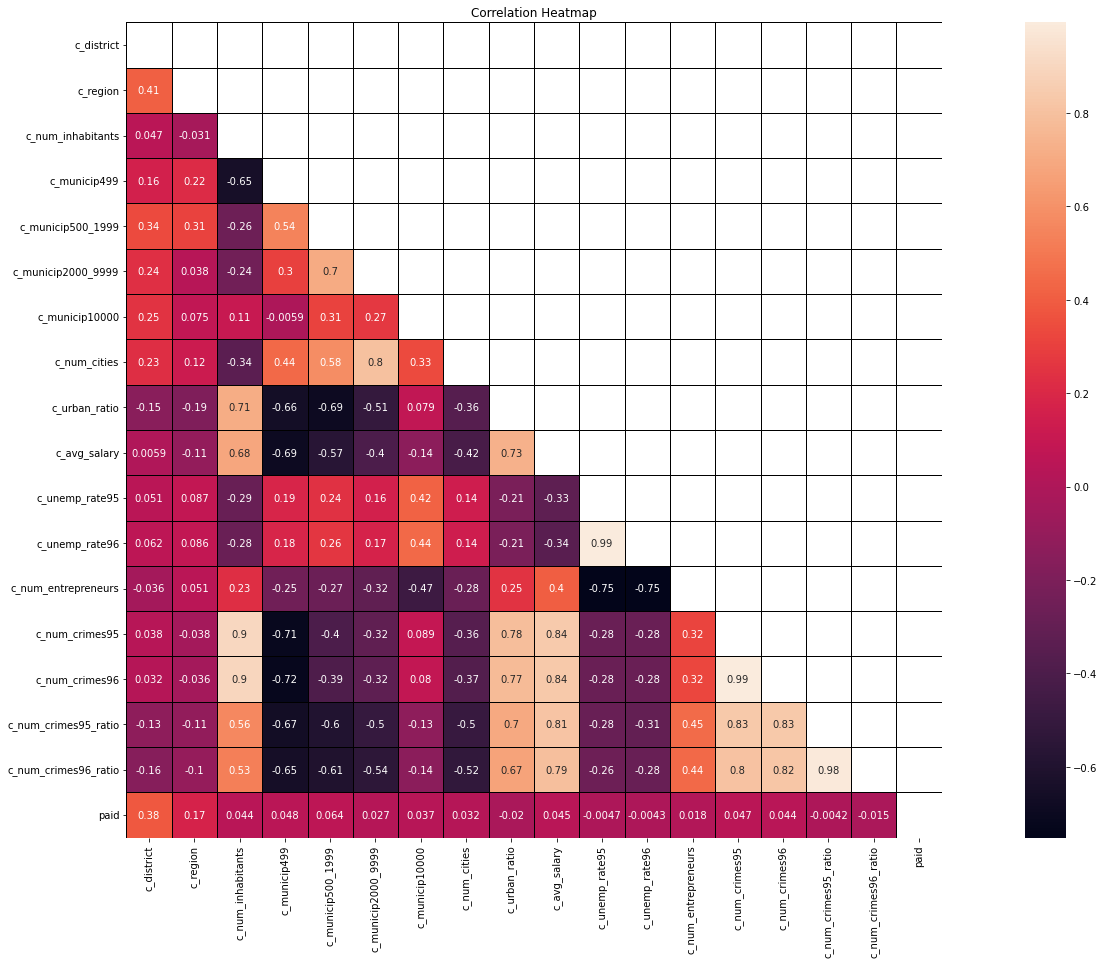

In [21]:
clientDistrictCols = ["c_district", "c_region", "c_num_inhabitants", "c_municip499", "c_municip500_1999", "c_municip2000_9999", "c_municip10000", 
    "c_num_cities", "c_urban_ratio", "c_avg_salary", "c_unemp_rate95", "c_unemp_rate96", "c_num_entrepreneurs", "c_num_crimes95", "c_num_crimes96", 
    "c_num_crimes95_ratio", "c_num_crimes96_ratio"]

su.plot_corr(joined_data, clientDistrictCols + ["paid"], methodName="spearman", annot=True, figSize=(30, 15))

As before, it gave basically no correlation between these features and paid, so we'll remove them

In [22]:
# TODO: Why do we keep the Account average salary, but drop the Client average salary? 
# Wouldn't the client average salary be more relevant? From the correlation with paid it seems that way

joined_data.drop(['c_num_inhabitants', 'c_municip499', 'c_municip500_1999', 'c_municip2000_9999', 'c_municip10000', 'c_num_cities', 
  'c_urban_ratio', 'c_unemp_rate95', 'c_unemp_rate96', 'c_num_entrepreneurs', 'c_num_crimes95', 'c_num_crimes96', 'c_num_crimes95_ratio'], axis='columns', inplace=True)

#"a_num_crimes96_ratio"

joined_data_comp.drop(['c_num_inhabitants', 'c_municip499', 'c_municip500_1999', 'c_municip2000_9999', 'c_municip10000', 'c_num_cities', 
  'c_urban_ratio', 'c_unemp_rate95', 'c_unemp_rate96', 'c_num_entrepreneurs', 'c_num_crimes95', 'c_num_crimes96', 'c_num_crimes95_ratio'], axis='columns', inplace=True)
#"a_num_crimes96_ratio"

joined_data

,frequency,a_date,is_co-owned,gender,a_district,a_region,a_avg_salary,a_num_crimes96_ratio,c_district,c_region,c_avg_salary,c_num_crimes96_ratio,loan_id,loan_date,amount,duration,payments,sanctions,household_mean,interest_mean,prev_year_balance,prev_6m_balance,prev_1m_balance,balance_min,balance_max,balance_mean,mean_year_influx,mean_6m_influx,mean_3m_influx,age,paid
0,weekly issuance,1993-03-22,0,0,0.859756,0.801928,9650,29.574315,0.619919,0.776867,9650,29.574315,5314,1993-07-05,96396,12,8033,0,7266.0,128.930000,12250.000000,12250.000000,20100.000000,1100.0,20100.0,12250.000000,1675.000000,3350.000000,6333.333333,2,0
1,monthly issuance,1993-02-13,0,1,0.964939,0.923409,8369,23.227959,0.859756,0.891046,8369,23.227959,5316,1993-07-11,165960,36,4610,0,15925.0,118.091667,52083.859459,52083.859459,33113.788889,700.0,120512.8,52083.859459,4350.741667,8701.483333,-12278.966667,1,1
2,monthly issuance,1993-02-08,0,1,0.971951,0.923409,8390,27.234108,0.971951,0.891046,8390,27.234108,6863,1993-07-28,127080,60,2118,0,6393.0,193.711111,30060.954167,30060.954167,36233.066667,800.0,49590.4,30060.954167,1689.416667,3378.833333,-2448.833333,3,1
3,monthly issuance,1993-01-30,0,0,0.976626,0.808117,10045,35.427665,0.837108,0.899018,8754,35.857977,5325,1993-08-03,105804,36,2939,0,0.0,252.633333,41297.480000,42976.541667,42535.133333,1000.0,65898.5,41297.480000,2857.716667,5548.766667,-990.000000,2,1
4,weekly issuance,1993-02-14,0,1,0.971951,0.882025,8288,16.876076,0.848080,0.848080,12541,82.249681,7240,1993-09-06,274740,60,4579,0,6256.0,122.200000,57188.211111,59364.680769,49872.757143,600.0,122893.1,57188.211111,3426.091667,6752.183333,-6138.033333,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,monthly issuance,1995-01-21,1,0,0.805432,0.766534,8994,40.721380,0.885976,0.785765,8994,40.721380,6818,1996-12-12,155616,48,3242,0,9810.0,213.500000,45928.792079,43900.685714,54345.971429,200.0,75294.1,44197.509884,-39.675000,-2094.533333,2870.900000,1,1
324,monthly issuance,1995-11-29,0,1,0.771951,0.801928,8843,19.425121,0.771951,0.776867,8843,19.425121,5625,1996-12-15,222180,60,3703,0,506.0,90.257143,57349.860714,63100.352632,67639.628571,800.0,130659.1,55230.444068,1975.916667,2524.833333,-4189.433333,3,0
325,monthly issuance,1996-05-21,0,0,0.896341,0.766534,10177,35.418572,0.885976,0.785765,10177,35.418572,6805,1996-12-21,45024,48,938,0,10886.0,189.125000,41994.907692,43750.788889,45877.944444,800.0,63659.3,41994.907692,3198.700000,1474.650000,130.366667,2,1
326,monthly issuance,1995-05-20,0,1,0.837108,0.808117,8427,20.366013,0.837108,0.801928,8427,20.366013,7233,1996-12-25,115812,36,3217,0,4518.0,163.472727,59966.281707,61231.792500,62714.766667,1100.0,119527.2,56646.516129,-1770.291667,-3588.533333,-11088.566667,2,1


# Frequency

As we can see from the joined_data, we still have frequency encoded as strings. We should perform encoding on that column. Since we have no order, We'll do one hot encoding

In [23]:
joined_data = ut.one_hot_encode(joined_data, ['frequency'])

joined_data_comp = ut.one_hot_encode(joined_data_comp, ['frequency'])

# Transaction

Lets see the correlation between the transaction related fields:

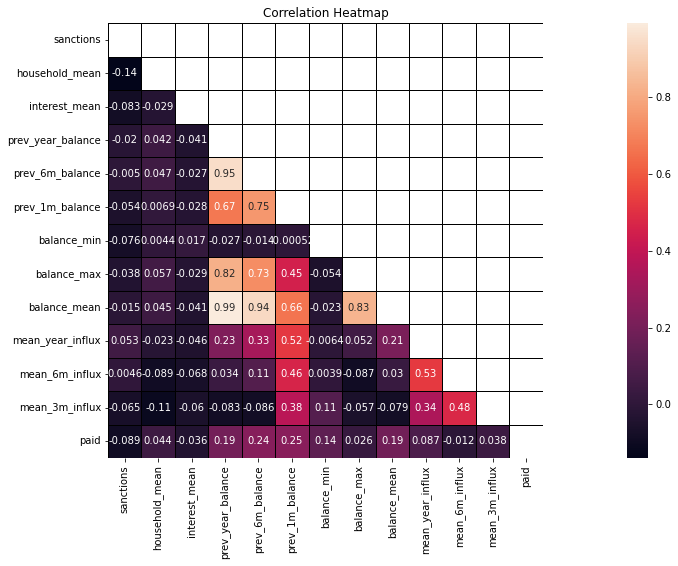

In [24]:
transactionCols = ["sanctions", "household_mean", "interest_mean", "prev_year_balance", "prev_6m_balance", "prev_1m_balance", 
"balance_min", "balance_max", "balance_mean", "mean_year_influx", "mean_6m_influx", "mean_3m_influx"]

su.plot_corr(joined_data, transactionCols + ["paid"], methodName="spearman", annot=True, figSize=(30, 8))

- As we see from the results, the previous year/6m/1m balance are highly correlated with the paid column, which is our target.
- On the other hand, the sanctions have a negative effect with the paid, which was expected
- The balance mean is highly correlated with prev year and pev 6m balance, so having prev year/6m/1m and balance mean columns is 
repeating information and we should discard some of those

We will then drop all the features except balance_mean and balance_min, that showed to be correlated with paid.

Let's keep in mind that other features (prev_6m, 1m, year) can be useful and we can use them later to test different algorithms
with different features 

## Balance Min and Influx

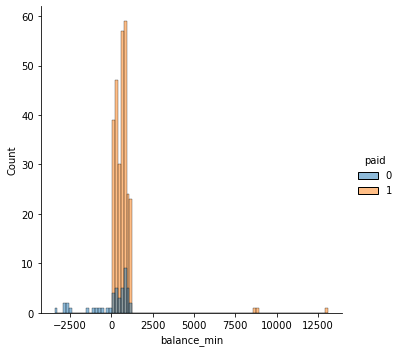

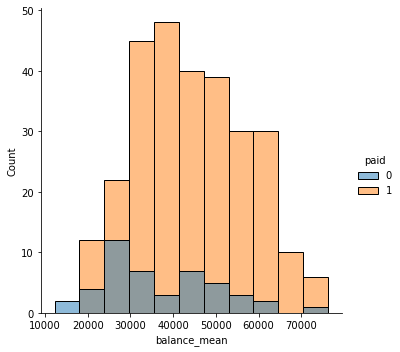

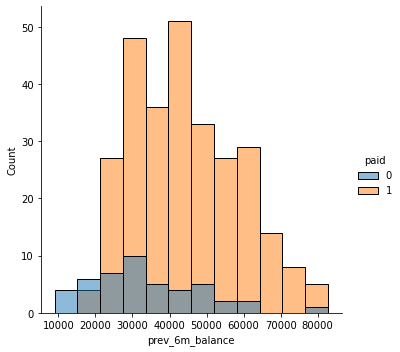

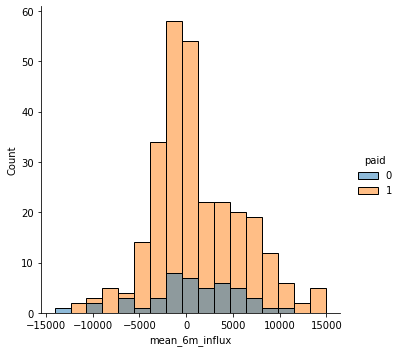

In [25]:
sb.displot(x="balance_min", data=joined_data, hue="paid")
sb.displot(x="balance_mean", data=joined_data, hue="paid")
sb.displot(x="prev_6m_balance", data=joined_data, hue="paid")

sb.displot(x="mean_6m_influx", data=joined_data, hue="paid")

From the graphs above, we clearly see that:
- When the balance_min is lower than 0, the loans are not paid, mean its highly correlated (as seen before)
- Despite of the high correlation of other columns with paid, doesn't seem to be a pattern on when the loans are paid or not.
- We can see that the balance mean and prev 6m are alike, so we can use just the balance_mean and discard the prev 1year 6m 1m columns

### Drop the transaction features said before

In [26]:
transDropCols = ["prev_year_balance", "prev_1m_balance", "mean_6m_influx"] 
#["sanctions", "household_mean", "interest_mean", "prev_year_balance", "prev_6m_balance", "prev_1m_balance", "balance_max", "mean_year_influx", "mean_6m_influx", "mean_3m_influx"]

joined_data.drop(transDropCols, axis='columns', inplace=True)

joined_data_comp.drop(transDropCols, axis='columns', inplace=True)

## Correlation between all the features of joined data

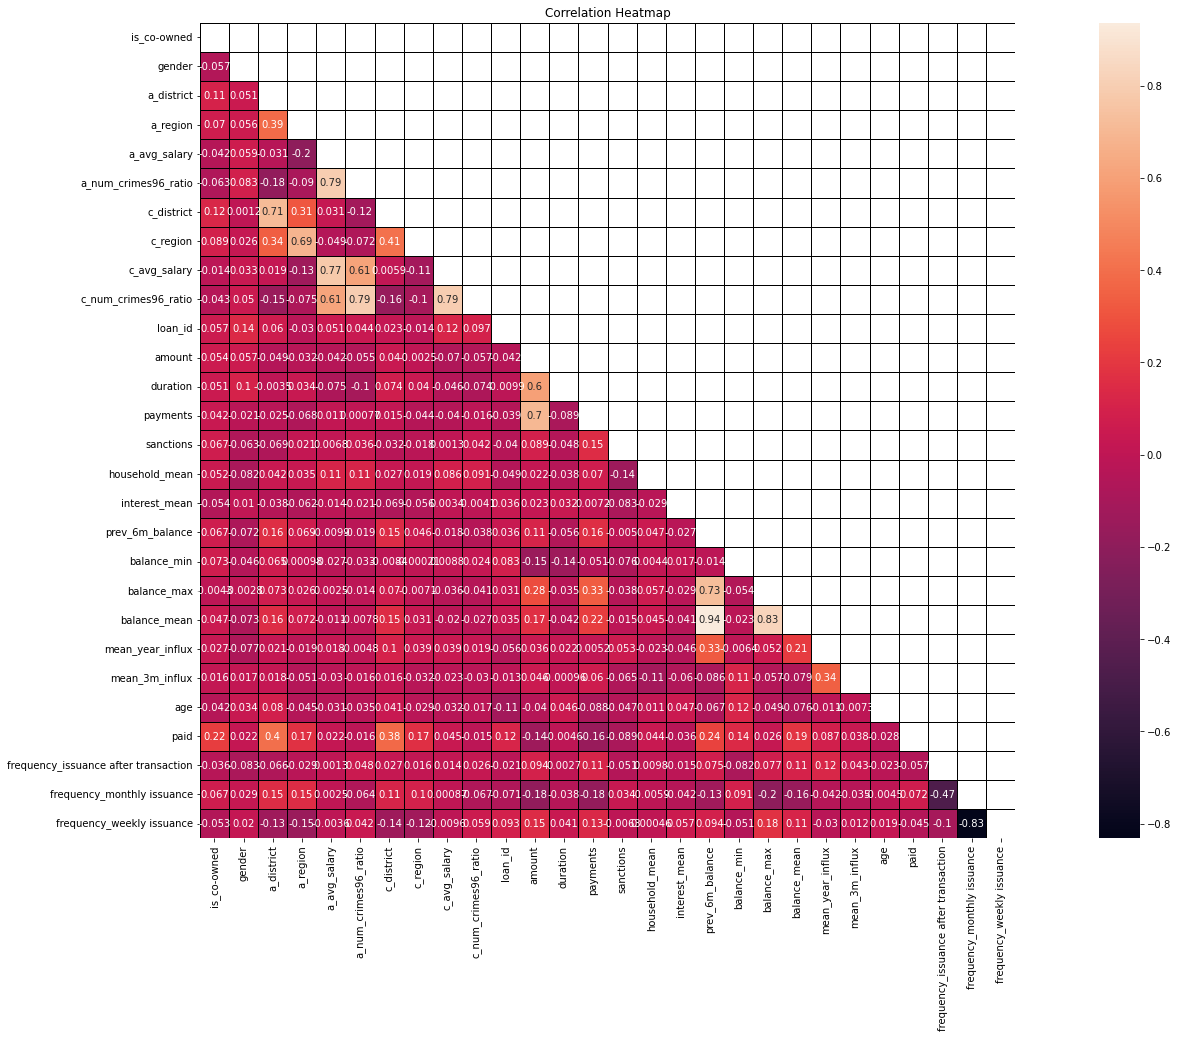

In [27]:
su.plot_corr(joined_data, joined_data.columns, methodName="spearman", annot=True, figSize=(30, 15))

As we see from above, we have high correlated features that doesn't bring much more information to the paid column, such as
the a_district with c_district and a_region with c_region. 

We can use statistical tests to confirm they are related
and discard any of them. Thus, we will discard the c_district and c_region.

The same happens with c_avg_salary and a_avg_salary, so we'll keep a_avg_salary

In [28]:
dropCols = ['c_district', 'c_region']#, 'c_avg_salary']

joined_data.drop(dropCols, axis='columns', inplace=True)
joined_data_comp.drop(dropCols, axis='columns', inplace=True)

In [29]:
joined_data

,a_date,is_co-owned,gender,a_district,a_region,a_avg_salary,a_num_crimes96_ratio,c_avg_salary,c_num_crimes96_ratio,loan_id,loan_date,amount,duration,payments,sanctions,household_mean,interest_mean,prev_6m_balance,balance_min,balance_max,balance_mean,mean_year_influx,mean_3m_influx,age,paid,frequency_issuance after transaction,frequency_monthly issuance,frequency_weekly issuance
0,1993-03-22,0,0,0.859756,0.801928,9650,29.574315,9650,29.574315,5314,1993-07-05,96396,12,8033,0,7266.0,128.930000,12250.000000,1100.0,20100.0,12250.000000,1675.000000,6333.333333,2,0,0,0,1
1,1993-02-13,0,1,0.964939,0.923409,8369,23.227959,8369,23.227959,5316,1993-07-11,165960,36,4610,0,15925.0,118.091667,52083.859459,700.0,120512.8,52083.859459,4350.741667,-12278.966667,1,1,0,1,0
2,1993-02-08,0,1,0.971951,0.923409,8390,27.234108,8390,27.234108,6863,1993-07-28,127080,60,2118,0,6393.0,193.711111,30060.954167,800.0,49590.4,30060.954167,1689.416667,-2448.833333,3,1,0,1,0
3,1993-01-30,0,0,0.976626,0.808117,10045,35.427665,8754,35.857977,5325,1993-08-03,105804,36,2939,0,0.0,252.633333,42976.541667,1000.0,65898.5,41297.480000,2857.716667,-990.000000,2,1,0,1,0
4,1993-02-14,0,1,0.971951,0.882025,8288,16.876076,12541,82.249681,7240,1993-09-06,274740,60,4579,0,6256.0,122.200000,59364.680769,600.0,122893.1,57188.211111,3426.091667,-6138.033333,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,1995-01-21,1,0,0.805432,0.766534,8994,40.721380,8994,40.721380,6818,1996-12-12,155616,48,3242,0,9810.0,213.500000,43900.685714,200.0,75294.1,44197.509884,-39.675000,2870.900000,1,1,0,1,0
324,1995-11-29,0,1,0.771951,0.801928,8843,19.425121,8843,19.425121,5625,1996-12-15,222180,60,3703,0,506.0,90.257143,63100.352632,800.0,130659.1,55230.444068,1975.916667,-4189.433333,3,0,0,1,0
325,1996-05-21,0,0,0.896341,0.766534,10177,35.418572,10177,35.418572,6805,1996-12-21,45024,48,938,0,10886.0,189.125000,43750.788889,800.0,63659.3,41994.907692,3198.700000,130.366667,2,1,0,1,0
326,1995-05-20,0,1,0.837108,0.808117,8427,20.366013,8427,20.366013,7233,1996-12-25,115812,36,3217,0,4518.0,163.472727,61231.792500,1100.0,119527.2,56646.516129,-1770.291667,-11088.566667,2,1,0,1,0


## Loan

As said in `statistics.ipynb`, we will discard the amount and duration and leave the payments column, since they are highly related
between each others and also with paid column, which is our target

In [30]:
loansDropCols = ["duration"]  # TODO: I don't think we can drop 2 of the 3 features. We should keep 2 of them since the 3rd can be derived
# "amount"
joined_data.drop(loansDropCols, axis='columns', inplace=True)
joined_data_comp.drop(loansDropCols, axis='columns', inplace=True)

joined_data

,a_date,is_co-owned,gender,a_district,a_region,a_avg_salary,a_num_crimes96_ratio,c_avg_salary,c_num_crimes96_ratio,loan_id,loan_date,amount,payments,sanctions,household_mean,interest_mean,prev_6m_balance,balance_min,balance_max,balance_mean,mean_year_influx,mean_3m_influx,age,paid,frequency_issuance after transaction,frequency_monthly issuance,frequency_weekly issuance
0,1993-03-22,0,0,0.859756,0.801928,9650,29.574315,9650,29.574315,5314,1993-07-05,96396,8033,0,7266.0,128.930000,12250.000000,1100.0,20100.0,12250.000000,1675.000000,6333.333333,2,0,0,0,1
1,1993-02-13,0,1,0.964939,0.923409,8369,23.227959,8369,23.227959,5316,1993-07-11,165960,4610,0,15925.0,118.091667,52083.859459,700.0,120512.8,52083.859459,4350.741667,-12278.966667,1,1,0,1,0
2,1993-02-08,0,1,0.971951,0.923409,8390,27.234108,8390,27.234108,6863,1993-07-28,127080,2118,0,6393.0,193.711111,30060.954167,800.0,49590.4,30060.954167,1689.416667,-2448.833333,3,1,0,1,0
3,1993-01-30,0,0,0.976626,0.808117,10045,35.427665,8754,35.857977,5325,1993-08-03,105804,2939,0,0.0,252.633333,42976.541667,1000.0,65898.5,41297.480000,2857.716667,-990.000000,2,1,0,1,0
4,1993-02-14,0,1,0.971951,0.882025,8288,16.876076,12541,82.249681,7240,1993-09-06,274740,4579,0,6256.0,122.200000,59364.680769,600.0,122893.1,57188.211111,3426.091667,-6138.033333,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,1995-01-21,1,0,0.805432,0.766534,8994,40.721380,8994,40.721380,6818,1996-12-12,155616,3242,0,9810.0,213.500000,43900.685714,200.0,75294.1,44197.509884,-39.675000,2870.900000,1,1,0,1,0
324,1995-11-29,0,1,0.771951,0.801928,8843,19.425121,8843,19.425121,5625,1996-12-15,222180,3703,0,506.0,90.257143,63100.352632,800.0,130659.1,55230.444068,1975.916667,-4189.433333,3,0,0,1,0
325,1996-05-21,0,0,0.896341,0.766534,10177,35.418572,10177,35.418572,6805,1996-12-21,45024,938,0,10886.0,189.125000,43750.788889,800.0,63659.3,41994.907692,3198.700000,130.366667,2,1,0,1,0
326,1995-05-20,0,1,0.837108,0.808117,8427,20.366013,8427,20.366013,7233,1996-12-25,115812,3217,0,4518.0,163.472727,61231.792500,1100.0,119527.2,56646.516129,-1770.291667,-11088.566667,2,1,0,1,0


## Drop Date columns

We have 2 columns as dates: a_date and loan_date. They seem to be very specific, since they are between 1993 and 1997.
This way, we will discard those columns

In [31]:
dateCols = ['a_date', 'loan_date']  # TODO: This explanation is not the best. We can't keep dates as they are, but I'm not sure we should just delete them

joined_data.drop(dateCols, axis='columns', inplace=True)
joined_data_comp.drop(dateCols, axis='columns', inplace=True)

joined_data

,is_co-owned,gender,a_district,a_region,a_avg_salary,a_num_crimes96_ratio,c_avg_salary,c_num_crimes96_ratio,loan_id,amount,payments,sanctions,household_mean,interest_mean,prev_6m_balance,balance_min,balance_max,balance_mean,mean_year_influx,mean_3m_influx,age,paid,frequency_issuance after transaction,frequency_monthly issuance,frequency_weekly issuance
0,0,0,0.859756,0.801928,9650,29.574315,9650,29.574315,5314,96396,8033,0,7266.0,128.930000,12250.000000,1100.0,20100.0,12250.000000,1675.000000,6333.333333,2,0,0,0,1
1,0,1,0.964939,0.923409,8369,23.227959,8369,23.227959,5316,165960,4610,0,15925.0,118.091667,52083.859459,700.0,120512.8,52083.859459,4350.741667,-12278.966667,1,1,0,1,0
2,0,1,0.971951,0.923409,8390,27.234108,8390,27.234108,6863,127080,2118,0,6393.0,193.711111,30060.954167,800.0,49590.4,30060.954167,1689.416667,-2448.833333,3,1,0,1,0
3,0,0,0.976626,0.808117,10045,35.427665,8754,35.857977,5325,105804,2939,0,0.0,252.633333,42976.541667,1000.0,65898.5,41297.480000,2857.716667,-990.000000,2,1,0,1,0
4,0,1,0.971951,0.882025,8288,16.876076,12541,82.249681,7240,274740,4579,0,6256.0,122.200000,59364.680769,600.0,122893.1,57188.211111,3426.091667,-6138.033333,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,1,0,0.805432,0.766534,8994,40.721380,8994,40.721380,6818,155616,3242,0,9810.0,213.500000,43900.685714,200.0,75294.1,44197.509884,-39.675000,2870.900000,1,1,0,1,0
324,0,1,0.771951,0.801928,8843,19.425121,8843,19.425121,5625,222180,3703,0,506.0,90.257143,63100.352632,800.0,130659.1,55230.444068,1975.916667,-4189.433333,3,0,0,1,0
325,0,0,0.896341,0.766534,10177,35.418572,10177,35.418572,6805,45024,938,0,10886.0,189.125000,43750.788889,800.0,63659.3,41994.907692,3198.700000,130.366667,2,1,0,1,0
326,0,1,0.837108,0.808117,8427,20.366013,8427,20.366013,7233,115812,3217,0,4518.0,163.472727,61231.792500,1100.0,119527.2,56646.516129,-1770.291667,-11088.566667,2,1,0,1,0


# Wrappers

In order to improve even more our feature Extraction, we'll use wrapper methods. These methods select features using a ML algorithm to assess the performance of models based on different subset of features.

We will use these 3 types of wrappers:
- Forward Selection
- Backward Selection
- Recursive Features Elimination

In [32]:
def get_features(df):
    return df.drop('paid', axis=1)
def get_target(df):
    return df.drop(df.columns.difference(['paid']), axis=1)

In [33]:
ANALYZE_WRAPPERS = True

Split Data into subsets and train a model using this. Based on the output of the model, add or subtract features and train the model again.
#### 1. Forward Selection

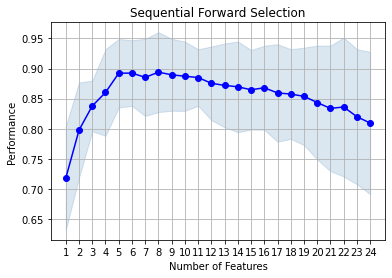

[[(2,)
  array([0.68125   , 0.72417154, 0.7202729 , 0.59920635, 0.86507937])
  0.7179960317460318 ('a_district',) 0.1107710326547218
  0.08618362666142448 0.04309181333071224]
 [(2, 16)
  array([0.86785714, 0.84210526, 0.68908382, 0.71527778, 0.87400794])
  0.797666388192704 ('a_district', 'balance_max') 0.10170484336480488
  0.07912982338562108 0.03956491169281053]
 [(2, 15, 16)
  array([0.88571429, 0.88693957, 0.82846004, 0.7827381 , 0.80555556])
  0.8378815093288777 ('a_district', 'balance_min', 'balance_max')
  0.054132557902754036 0.04211696910925232 0.02105848455462616]
 [(2, 9, 15, 16)
  array([0.89910714, 0.97660819, 0.84990253, 0.77777778, 0.79761905])
  0.8602029379003062
  ('a_district', 'amount', 'balance_min', 'balance_max')
  0.09247034935450976 0.07194507331949888 0.03597253665974944]
 [(0, 2, 9, 15, 16)
  array([0.925     , 0.98050682, 0.88401559, 0.81448413, 0.85714286])
  0.892229880256196
  ('is_co-owned', 'a_district', 'amount', 'balance_min', 'balance_max')
  0.073

In [35]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

if ANALYZE_WRAPPERS:
    originalFeatures = get_features(joined_data)
    x = originalFeatures
    y = joined_data['paid']

    def forward_selection(featuresData, target, k_features = 20):
        sfs = SFS(RandomForestClassifier(),
                k_features=k_features,
                forward=True,
                floating=False,
                cv = 5,
                scoring = 'roc_auc',
                n_jobs = -1)
        sfs = sfs.fit(featuresData, target)
        fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
        plt.title('Sequential Forward Selection')
        plt.grid()
        plt.show()
        return pd.DataFrame.from_dict(sfs.get_metric_dict()).T


    forward_selection_result = forward_selection(x, y, k_features = joined_data.shape[1] - 1)

    print(forward_selection_result.values)
    # According to this, the last 4 features reduce the performance of the model

#### 2. Backward Elimination

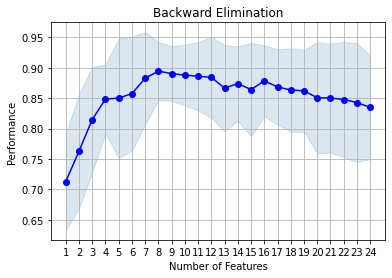

[[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23)
  array([0.79107143, 0.97270955, 0.88693957, 0.73015873, 0.79365079])
  0.8349060150375941
  ('is_co-owned', 'gender', 'a_district', 'a_region', 'a_avg_salary', 'a_num_crimes96_ratio', 'c_avg_salary', 'c_num_crimes96_ratio', 'loan_id', 'amount', 'payments', 'sanctions', 'household_mean', 'interest_mean', 'prev_6m_balance', 'balance_min', 'balance_max', 'balance_mean', 'mean_year_influx', 'mean_3m_influx', 'age', 'frequency_issuance after transaction', 'frequency_monthly issuance', 'frequency_weekly issuance')
  0.1095031107564766 0.08519714034911557 0.04259857017455778]
 [(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23)
  array([0.775     , 0.97465887, 0.92105263, 0.70238095, 0.84126984])
  0.8428724589250904
  ('is_co-owned', 'gender', 'a_district', 'a_region', 'a_avg_salary', 'a_num_crimes96_ratio', 'c_avg_salary', 'c_num_crimes96_ratio', 'loan_id', 'amount', 'pa

In [36]:
def backward_selection(featuresData, target, k_features = 1):
    sbs = SFS(RandomForestClassifier(),
              k_features=k_features,
              forward=False,
              floating=False,
              scoring = 'roc_auc',
              cv = 5,
              n_jobs = -1)
    sbs = sbs.fit(featuresData, target)
    fig1 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')
    plt.title('Backward Elimination')
    plt.grid()
    plt.show()
    return pd.DataFrame.from_dict(sbs.get_metric_dict()).T

if ANALYZE_WRAPPERS:
    backward_selection_result = backward_selection(x, y)
    print(backward_selection_result.values)

#### 3. Bi-directional Elimination (Step-wise Selection)

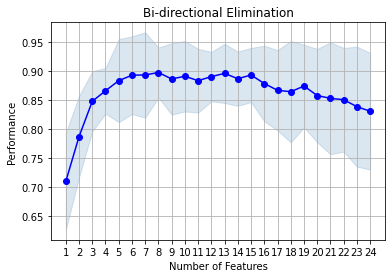

In [37]:
def bi_directional_elimination(featuresData, target, k_features = (1, 20)):
    sffs = SFS(RandomForestClassifier(),
              k_features=k_features,
              forward=True,
              floating=True,
              scoring = 'roc_auc',
              cv = 5,
              n_jobs = -1)
    sffs = sffs.fit(featuresData, target)
    fig1 = plot_sfs(sffs.get_metric_dict(), kind='std_dev')
    plt.title('Bi-directional Elimination')
    plt.grid()
    plt.show()
    return pd.DataFrame.from_dict(sffs.get_metric_dict()).T

if ANALYZE_WRAPPERS:
    bi_directional_elimination_result = bi_directional_elimination(x, y, k_features = (1, joined_data.shape[1] - 1))
    bi_directional_elimination_result

### Compare Results

In [38]:
if ANALYZE_WRAPPERS:
    # Change 'avg_score' to float
    forward_selection_result['avg_score'] = forward_selection_result['avg_score'].astype(float)
    backward_selection_result['avg_score'] = backward_selection_result['avg_score'].astype(float)
    bi_directional_elimination_result['avg_score'] = bi_directional_elimination_result['avg_score'].astype(float)

    numOfFeatures = 12
    # Find the best result for each method
    backward_selection_result['avg_score'] == backward_selection_result['avg_score'].max()
    a = forward_selection_result.iloc[forward_selection_result['avg_score'].idxmax()]
    b = backward_selection_result.iloc[numOfFeatures - backward_selection_result['avg_score'].idxmax()]
    c = bi_directional_elimination_result.iloc[bi_directional_elimination_result['avg_score'].idxmax()]

    c_df = pd.DataFrame({
        'method': ['forward selection', 'backward elimination', 'bi-directional'],
        'feature_names': [a['feature_names'], b['feature_names'], c['feature_names']],
        'n_features': [len(a['feature_names']), len(b['feature_names']), len(c['feature_names'])],
        'avg_score': [a['avg_score'], b['avg_score'], c['avg_score']]  
    })

    c_df

As we can see, the results are very similar, but the forward selection method is the one that gave us the best results. Thus, we will use it to select the best features.

In [39]:
if ANALYZE_WRAPPERS:
    forward_selection_result.values

If we use the 8 features, we need to drop the following columns: *gender*, *a_region*, *frequency_weekly issuance*, and *a_avg_salary*

In [40]:
USE_WRAPPED = True  # Boolean variable that indicates whether to use the wrapped data or not

if USE_WRAPPED:
    wrapper_columns = ['loan_id', 'paid', 
    'amount', 'payments', 'is_co-owned', 
    'balance_min', 'balance_mean', 'mean_3m_influx', 
    'frequency_monthly issuance', 'frequency_weekly issuance']
    #'age', 'balance_max', 'mean_year_influx', 'prev_6m_balance', 'gender', 'a_district', 'sanctions'
    joined_data = joined_data[wrapper_columns]
    joined_data_comp = joined_data_comp[wrapper_columns]
    #joined_data.drop(wrapper_drop_columns, axis='columns', inplace=True)
    #joined_data_comp.drop(wrapper_drop_columns, axis='columns', inplace=True)

### Save Dataset

In [41]:
import os

PATH = '../../assets/final'
FINAL_FILE_DEV = "/data.csv"
FINAL_FILE_COMP = "/kaggleData.csv"


if not os.path.exists(PATH):
  os.mkdir(PATH)

joined_data.to_csv(PATH + FINAL_FILE_DEV, index=False)
joined_data_comp.to_csv(PATH + FINAL_FILE_COMP, index=False)


In [42]:
IS_LOADED = True